## Application of causal discovery and causal inference methods to climate dynamics problem
##### Here, this notebook shows and explains step by step a causal approach to analyse linkages among ENSO, circulation fields, and summer monsoon precipitation over the Himalayas.

In [18]:
from warnings import filterwarnings
filterwarnings("ignore")

from src.DataProcessingClass import DataProcessingClass
from src.CausalityClass import CausalityClass

#### Preprocessing of climate indices (or time series data): 
#### ENSO - El Niño–Southern Oscillation
#### WC - Walker cell
#### MHC - Monsoon Hadley cell
#### Himalayan precipitation

In [19]:
# Create a class instance for data preprocessing
dpc = DataProcessingClass()

# Load climate indices from netCDF files.
D = dpc.load_netcdf_files()

Input dir path: data/
Selected indices:  ['enso', 'mhc', 'precip']
['enso.nc', 'mhc.nc', 'precip.nc', 'wc.nc']
enso
mhc
precip
wc
not in wc.nc
List of files
enso.nc
mhc.nc
precip.nc


#### Plot the location of the WC/HP and MHC indices

<xarray.Dataset>
Dimensions:    (time: 1, latitude: 721, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables:
    orog       (time, latitude, longitude) float64 ...
Attributes:
    Conventions:  CF-1.5


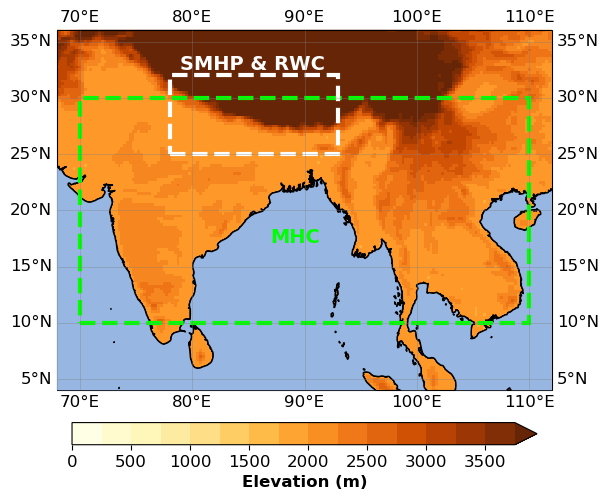

In [20]:
dpc.plot_orography_map()

#### Transfrom precipitation data with logarithmic function

In [21]:
# Apply log transform
ind_name='precip'
if ind_name in list(D.keys()): dpc.transform_precip(D, ind_name=ind_name, apply_transform=True)

#### Apply ADF and KPSS statistical tests to indices to check for the stationarity 

In [22]:
# Use the Augmented Dickey-Fuller unit root test and Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
dpc.adf_kpss_tests(D)

Index: enso
Significance level: 0.05
ADF test: test statistics; p-value:  -7.065785772885115 5.085032990994129e-10
KPSS test: test statistics; p-value:  0.07138192512351936 0.1
Yes, the index is stationary.

Index: mhc
Significance level: 0.05
ADF test: test statistics; p-value:  -6.764301743988442 2.7418971521246714e-09
KPSS test: test statistics; p-value:  0.20256524111057098 0.1
Yes, the index is stationary.

Index: precip
Significance level: 0.05
ADF test: test statistics; p-value:  -5.087714502108937 1.483873363800904e-05
KPSS test: test statistics; p-value:  0.2821750549338365 0.1
Yes, the index is stationary.



#### 1) Based on the result of statitiscal test perform detrending of WC index
#### 2) Remove climatological and seasonal cycles
#### 3) Normalise indices to a common range
#### 4) Select datapoint from climate indices from a specified timeframe of our interest

In [23]:
# Select index
ind_name = 'wc'

if ind_name in list(D.keys()): dpc.detrend_index(D, ind_name)

# Remove means
dpc.remove_means(D)

# Apply min max normalisation
dpc.min_max_norm(D)

# Select datapoint for May-September from each year for 1940-2022
dpc.select_datapoints(D)


#### Calculate lagged cross-correlations for all pairs of climate indices

In [24]:
# Choose max lag time
n_lags = -2

dpc.test_pairs_lag_corr(D, n_lags)

Pair: enso-->mhc
Computing lagged cross-correlations at lags: [ 0 -1 -2]
0 PearsonRResult(statistic=-0.16745723919992023, pvalue=0.000614141046376721)
-1 PearsonRResult(statistic=-0.1222119742054426, pvalue=0.012829700722352795)
-2 PearsonRResult(statistic=0.0393378912173375, pvalue=0.4252616733350374)


Pair: enso-->precip
Computing lagged cross-correlations at lags: [ 0 -1 -2]
0 PearsonRResult(statistic=-0.12025727692182964, pvalue=0.014232547925402414)
-1 PearsonRResult(statistic=-0.1513678594610773, pvalue=0.002012496404817756)
-2 PearsonRResult(statistic=0.023379627040393945, pvalue=0.6356747156730398)


Pair: mhc-->enso
Computing lagged cross-correlations at lags: [ 0 -1 -2]
0 PearsonRResult(statistic=-0.16745723919992023, pvalue=0.000614141046376721)
-1 PearsonRResult(statistic=-0.023047347987706676, pvalue=0.6400789562793144)
-2 PearsonRResult(statistic=-0.035593373942472875, pvalue=0.4706763073291425)


Pair: mhc-->precip
Computing lagged cross-correlations at lags: [ 0 -1 -2]

#### Build a causal graph using PCMCI algorithm.

In [25]:
# Create a class instance with climate indices
ca = CausalityClass(D)

# Construct a custom dataframe format used by Tigramite package
dataframe, _ = ca.generate_dataframe(D) 

# Build the causal graph with PCMCI algorithm
sig_causal_parents = ca.construct_causal_graph(dataframe)

matched_indexes ['enso' 'mhc' 'precip']
var_names ['enso', 'mhc', 'precip']
matched_labels ['ENSO', 'MHC', 'SMHP']
Input Indices: (415, 3)
Dataframe size: (415, 3)
results['val_matrix'] [[[ 0.          0.10827966]
  [ 0.         -0.12471849]
  [ 0.         -0.15833777]]

 [[ 0.         -0.0017117 ]
  [ 0.          0.14995681]
  [ 0.          0.1669555 ]]

 [[ 0.         -0.0031659 ]
  [ 0.         -0.1717409 ]
  [ 0.         -0.27083896]]]

## Significant links at alpha = 0.05:

    Variable ENSO has 1 link(s):
        (ENSO -1): pval = 0.02798 | qval = 0.03597 | val =  0.108

    Variable MHC has 3 link(s):
        (SMHP -1): pval = 0.00049 | qval = 0.00213 | val = -0.172
        (MHC -1): pval = 0.00239 | qval = 0.00430 | val =  0.150
        (ENSO -1): pval = 0.01149 | qval = 0.01723 | val = -0.125

    Variable SMHP has 3 link(s):
        (SMHP -1): pval = 0.00000 | qval = 0.00000 | val = -0.271
        (MHC -1): pval = 0.00071 | qval = 0.00213 | val =  0.167
        (ENSO -1): pva

#### Use linear estimator to compute beta coefficients on the build causal graph

In [26]:
# Fit the linear estimator
val_matrix, link_matrix = ca.linear_estimator(sig_causal_parents, dataframe)

# Get the beta coefficients for the causal graph
ca.get_links_beta_coeffs()


### Beta coefficients for:

0 ENSO
1 MHC
2 SMHP
             0         1         2
0 -1  0.099544 -0.123943 -0.268103
2 -1       NaN -0.118645 -0.274575
1 -1       NaN  0.161238  0.325824


In [27]:
ca.linear_mediator.get_coefs()

{0: {(0, -1): 0.09954373137809289},
 1: {(2, -1): -0.11864520543589832,
  (1, -1): 0.16123817665965656,
  (0, -1): -0.12394349291480794},
 2: {(2, -1): -0.27457476675752374,
  (1, -1): 0.32582449831683674,
  (0, -1): -0.26810274988067345}}

In [28]:
ca.linear_mediator.get_coeff(i=0, tau=1, j=0)

0.09954373137809289

In [29]:
ca.linear_mediator.get_coeff(i=1, tau=1, j=1)

0.16123817665965656

In [30]:
ca.linear_mediator.get_coeff(i=2, tau=1, j=2)

-0.27457476675752374

#### Plot the causal graph a causal effect network 

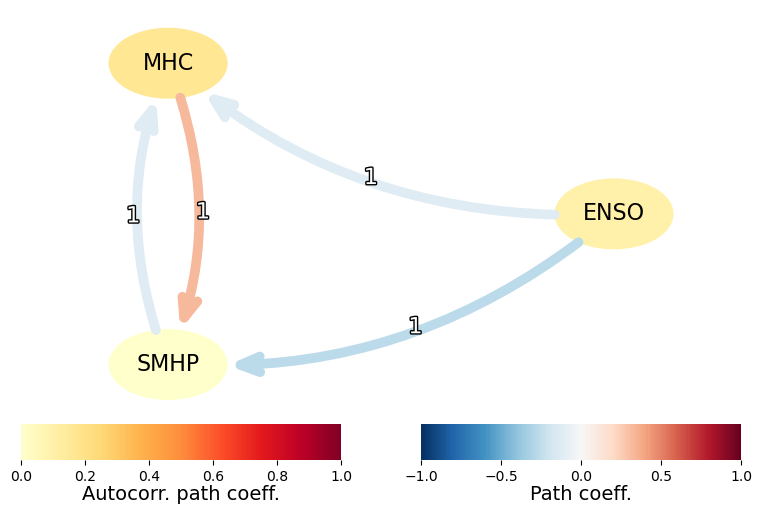

In [31]:
# Plot causal effect network and save it to a png format
ca.plot_cens_graph(val_matrix, link_matrix, save=True)

#### Apply bootstrapping to estimate the statisical robustness of the causal links